<h2 id='part1'>CRISP-DM Process of the Seatle Airbnb Data</h2>
This Notebook illustrates the stepwise CRISP-DM process applied to the Seatle Airbnb Data

<h3 id='q1'>Section 1: Business Understanding</h3>
The Notebook answers the following Business questions:

   **1.** Is there a correlation between listings with higher ratings and price tag ? We want to know if pricier listings generally have better ratings.
   
   **2.** Are some locations generally more expensive than other locations ?
   
   **3.** Do some locations get better cleanliness ratings ?
   
   **4.** Are expensive locations also the cleanest locations ?

<h3 id='q1'>Section 2: Data Understanding 1</h3>

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

***Reading in the data***

In [26]:
df_calendar = pd.read_csv('./calendar.csv')
df_listings = pd.read_csv('./listings.csv')
df_reviews = pd.read_csv('./reviews.csv')

***Visualizing the data feilds***

In [27]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [28]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [29]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


***Checking the percentage of nulls in the calendar dataset***

In [30]:
df_calendar['price'].isnull().mean()

0.32938998399793334

***Checking the shape of the calendar dataset***

In [31]:
df_calendar.shape

(1393570, 4)

***Checking for unique values in the calendar dataset***

In [32]:
len(pd.unique(df_calendar['listing_id']))

3818

***Checking the shape of the listings dataset***

In [33]:
df_listings.shape

(3818, 92)

***Checking the data type of the price column***

In [34]:
df_calendar['price'][0]

'$85.00'

<h3 id='q1'>Section 3: Data Preparation 1</h3>

***Drop Nan rows***

The Nan values of the calendar dataset need to be dropped because they do not help in answering question 1 posed. The average prices across the listings is needed and Nan values do not contribute to averages. 

In [35]:
df_calendar_dropna = df_calendar.dropna(subset=['price'], how='any')

In [36]:
def convertStringToFloat(x):
    
    ''' returns a float for each row in the price column that is a string
    
    input: a row of data in the prices column
    
    output: the converted value from string to float
    '''
    
    return float(x.replace('$','').replace(',',''))

***Convert Price to float***

As identified earlier, the price column contains strings and it needs to be converted to float(numerical) to allow for its correlation with the ratings column.

In [37]:
# df_calendar_dropna['price'] = df_calendar_dropna['price'].apply(lambda x: float(x.replace('$','').replace(',','')))

In [38]:
df_calendar_dropna['price'] = df_calendar_dropna['price'].apply(convertStringToFloat)

/var/folders/qz/6vwxy__j4jv671j87ggt5prm0000gn/T/ipykernel_14622/1965064740.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calendar_dropna['price'] = df_calendar_dropna['price'].apply(convertStringToFloat)


***Aggregate listings by mean price***

As mentioned earlier we need the average prices across the listings in the calendar dataste to allow for correlation with the ratings column in the listings dataset

In [39]:
df4 = df_calendar_dropna.groupby('listing_id').agg({'price':'mean' })

In [40]:
df4.shape

(3723, 1)

As we can see from the above, the number of listings has dropped from 3818 to 3723 meaning some of the listings had Nan values throughout the dates. Such Nan values are not useful for our analysis. This concludes the preparation of the calendar dataset

In [41]:
df4.head()

,price
listing_id,
3335,120.000000
4291,82.000000
5682,53.944984
6606,92.849315
7369,85.000000


Preparing the listings dataset for a merge with the prepared calendar dataset

***Check for Nan Values***

In [42]:
df_listings[['review_scores_rating']].isnull().mean()

review_scores_rating    0.16946
dtype: float64

***Drop Nans and select required columns***

Similar to the Nans in the calendar dataset, Nans will not help us to correlate average prices of the listings with the ratings column, hence, they need to be dropped

In [43]:
df5 = df_listings.dropna(subset='review_scores_rating')

In [44]:
df6 = df5[['id','review_scores_rating']]

***Merge listings dataset with calendar dataset***

An inner merge was necessary so that only listings common to both datasets would remain after the merge. This would make it easy to correlate the columns

In [45]:
inner_merged_df7 = pd.merge(df4, df6, left_on='listing_id', right_on='id')

In [46]:
inner_merged_df7.shape

(3101, 3)

In [47]:
inner_merged_df7.head()

,price,id,review_scores_rating
0,82.000000,4291,92.0
1,53.944984,5682,96.0
2,92.849315,6606,93.0
3,85.000000,7369,94.0
4,85.616438,9419,91.0


As can be seen from the above cells, the dataset has further dropped to 3101 listings which have the necessary values for a valuable correlation. 

<h3 id='q1'>Section 5: Evaluation of results</h3>

Now, the data is ready for analysis using scatter plots and correlation coefficient

<h4 id='q1'>Solution to Question 1</h4> Is there a correlation between listings with higher ratings and price tag ?

***Plot your data***

<AxesSubplot:xlabel='review_scores_rating', ylabel='price'>

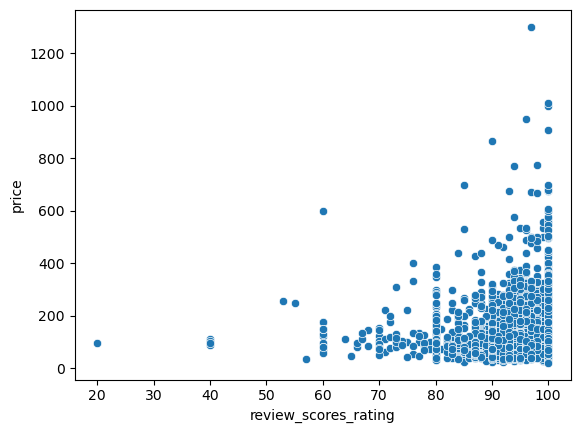

In [48]:
sns.scatterplot(x="review_scores_rating", y="price", data=inner_merged_df7)

***Calculate correlation coefficient***

In [49]:

stats.pearsonr(inner_merged_df7['review_scores_rating'], inner_merged_df7['price'])

PearsonRResult(statistic=0.06487541572111183, pvalue=0.00030029563280570363)

A 6.5% correlation shows that pricier listings do not necessarily have higher ratings. The graph shows that there are sizable number of cheap listings with good ratings

<h3 id='q1'>Section 2: Data Understanding 2</h3>

To answer the second question, we need to understand the fields that will help us answer location based questions

In [50]:
df_listings['review_scores_cleanliness'].head()

0    10.0
1    10.0
2    10.0
3     NaN
4     9.0
Name: review_scores_cleanliness, dtype: float64

***Get number of unique values in the zipcode column***

In [51]:
len(pd.unique(df_listings['zipcode']))

29

***Get number of unique values in the streets column***

In [52]:
len(pd.unique(df_listings['street']))

1442

As can be seen from the above, the streets column is too granular. Hence, we will use the zipcode column for locations

***Get percentage of nulls***

In [53]:
df_listings[['zipcode']].isnull().mean()

zipcode    0.001833
dtype: float64

<h3 id='q1'>Section 3: Data Preparation 2</h3>

***Drop Nans and select required columns***

Because we are trying to visualize the average prices per location (zipcode), a Nan value in the zipcode column is not helpful and is , hence, dropped

In [54]:
df11 = df_listings.dropna(subset='zipcode')

In [55]:
df12 = df11[['id','zipcode']]

***Merge datasets***

We merge the listings dataset containing the zipcodes with the calendar dataset with average prices per listing

In [56]:
inner_merged_df13 = pd.merge(df4, df12, left_on='listing_id', right_on='id')

<h3 id='q1'>Section 5: Evaluation of results 2</h3>

Now, the data is ready for analysis using aggregated tables

***Group zipcodes by average prices and sort in descending order***

In [57]:
df14 = inner_merged_df13.groupby('zipcode').agg({'price':'mean'}).sort_values('price',ascending=False)

<h4 id='q1'>Solution to Question 2</h4> Are some locations generally more expensive than other locations ?

***Get Most Expensive zipcodes***

In [58]:
df14.head()

,price
zipcode,
98134,213.401463
98101,194.623749
98199,186.698470
98121,183.572409
98119,175.977182


***Get least expensive zipcodes***

In [59]:
df14.tail()

,price
zipcode,
98125,91.957781
98133,89.064697
98106,86.692376
98108,86.681967
99\n98122,67.000000


<h4 id='q1'>Solution to Question 3 and 4</h4>

Do some locations get better cleanliness ratings ?

Are expensive locations also the cleanest locations ?

***Group zipcodes by mean cleanliness scores***

In [60]:
df15 = df11.groupby('zipcode').agg({'review_scores_cleanliness':'mean'}).sort_values('review_scores_cleanliness',ascending=False)

***Get cleanest zipcodes***

In [61]:
df15.head()

,review_scores_cleanliness
zipcode,
98116,9.788889
98178,9.750000
98126,9.744681
98119,9.739496
98177,9.733333


***Get least clean zipcodes***

In [62]:
df15.tail()

,review_scores_cleanliness
zipcode,
98104,9.474359
98102,9.441176
98133,9.342857
98105,9.234286
99\n98122,8.000000


Since the zipcodes that are the most expensive do not occur in the top cleanest zipcodes, we can conclude that pricier loactions are not necessarily the cleanest which answers question 4